In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import json
import seaborn as sns
from scipy.stats import ttest_1samp
import re
import operator
import sys
sys.path.append('..')
from helpers.funcs import *

In [4]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']

In [5]:
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))
time_dict = json.load(open(INPUT_DIR + "event_year.json","r"))

In [21]:
events

['chattanooga',
 'roseburg',
 'colorado_springs',
 'san_bernardino',
 'kalamazoo',
 'orlando',
 'dallas',
 'baton_rouge',
 'burlington',
 'fort_lauderdale',
 'fresno',
 'san_francisco',
 'vegas',
 'thornton',
 'sutherland_springs',
 'parkland',
 'nashville',
 'santa_fe',
 'annapolis',
 'pittsburgh',
 'thousand_oaks']

In [26]:
e = 'parkland'
tweets = pd.read_csv(TWEET_DIR +e+'/'+e+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'remove', 'isRT', 'dem_follows', 'rep_follows'])
tweets = filter_retweets(tweets)
t = tweets[tweets['text'].str.contains('terrorist', case=False)] 

In [27]:
for s in t.sample(20)['text']:
    print(s)

4/5 - This isn't about self-defense or a militia protecting the people from tyranny; this is about recognizing that the war on terrorism starts right here in this country. . . #Parklandshooting #parklandshooter #terrorist #terrorism #america #thoughtsandprayersarentenough
How long are you going to pretend #immigration is your biggest problem when you know #WhiteSupremacy are poisoning the minds of #whiteAmericans and they are #America #DomesticTerrorist. #ParklandSchoolShooting is just another example of @NRA and #WhiteSupremacy
Are We Winning the War on Terrorism ?!! - He is a homegrown terrorist - We are Anonymous, We do not forgive, We do not forget, Expect us >>>Today a new message to the American people - Follow Now @_Anonymous_USA_ #GunControlNow #Parkland #Florida #GunReformNow #NikolasCruz
Waiting for the parkland shooter to be addressed as a terrorist...
RT this! Terrorists NRA being brought to light by Father of Parkland School Shooting! #CodeRedTerroristAlert #NRATerroistAle

In [7]:
def get_df(word):
    log_odds_list = []
    vocab_size = []
    event_names = []
    race = []
    time = []
    odds_dem = []
    odds_rep = []
    odds_overall = []
    mutual_information = []
    posterior = []
    chi_square = []
    for e in events:
        # format name
        name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
        log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds.npy')
        vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
        words2idx = {w: i for i, w in enumerate(vocab)}
    
        # keep words / phrases if they occur at least ten times
        vocab_log_odds = {w: log_odds[3,i] for i, w in enumerate(vocab) if log_odds[0,i]}
        if word not in vocab_log_odds:
            #print('missing:', name)
            continue
        rep_all = log_odds[1, :].sum()
        dem_all = log_odds[2, :].sum()
        prior_all = log_odds[0, :].sum()
        rep_odds = {w: log_odds[1,i] / (dem_all-log_odds[1,i]) for i, w in enumerate(vocab)}
        dem_odds = {w: log_odds[2,i] / (dem_all-log_odds[2,i]) for i, w in enumerate(vocab)}
        overall_odds = {w: log_odds[0,i] / (prior_all-log_odds[0,i]) for i, w in enumerate(vocab)}
        post =  {w: log_odds[4,i] for i, w in enumerate(vocab)}
        mi =  {w: log_odds[5,i] for i, w in enumerate(vocab)}
        chi =  {w: log_odds[6,i] for i, w in enumerate(vocab)}

        
        event_names.append(name)
        vocab_size.append(log_odds.shape[1])
        log_odds_list.append(vocab_log_odds[word])
        odds_dem.append(dem_odds[word])
        odds_rep.append(rep_odds[word])
        odds_overall.append(overall_odds[word])
        posterior.append(post[word])
        mutual_information.append(mi[word])
        chi_square.append(chi[word])
        print(name)
        race.append(shooter_race[e])
        
        time.append(time_dict[e])
    df = pd.DataFrame.from_dict({'event': event_names, 'log_odds':log_odds_list, 'vocab_size':vocab_size, 'race':race, 'time': time, 'dem_odds':odds_dem, 'rep_odds':odds_rep, 'overall_odds': odds_overall, 'mutual_information':mutual_information, 'posterior': posterior, 'chi_square':chi_square})
    df.sort_values('vocab_size', ascending=False, inplace=True)
    df['odds_ratio'] = np.exp(df['log_odds'])
    df['odds_abs']= np.abs(df['log_odds'])
    df.index = df['event']
    return df

In [8]:
def get_multi(words):
    dfs = []
    for w in words:
        print(w)
        df = get_df(w)
        df['word'] = '"' + w + '"'
        dfs.append(df)
        print('-----')
    return pd.concat(dfs, ignore_index=True)

In [9]:
concat = get_multi(['terrorist', 'lone wolf', 'mental', 'shooter', 'crazi person', "crazi", 'ill'])

terrorist
Chattanooga
Roseburg
Colorado Springs
San Bernardino
Kalamazoo
Orlando
Dallas
Baton Rouge
Burlington
Fort Lauderdale
Fresno
Vegas
Thornton
Sutherland Springs
Parkland
Nashville
Santa Fe
Annapolis
Pittsburgh
Thousand Oaks
-----
lone wolf
Chattanooga
Colorado Springs
Orlando
Dallas
Vegas
Sutherland Springs
-----
mental
Chattanooga
Roseburg
Colorado Springs
San Bernardino
Kalamazoo
Orlando
Dallas
Baton Rouge
Fresno
San Francisco
Vegas
Thornton
Sutherland Springs
Parkland
Nashville
Santa Fe
Annapolis
Pittsburgh
Thousand Oaks
-----
shooter
Chattanooga
Roseburg
Colorado Springs
San Bernardino
Kalamazoo
Orlando
Dallas
Baton Rouge
Burlington
Fort Lauderdale
Fresno
San Francisco
Vegas
Thornton
Sutherland Springs
Parkland
Nashville
Santa Fe
Annapolis
Pittsburgh
Thousand Oaks
-----
crazi person
Orlando
Vegas
Parkland
-----
crazi
Chattanooga
Roseburg
Colorado Springs
San Bernardino
Kalamazoo
Orlando
Dallas
Baton Rouge
Fort Lauderdale
San Francisco
Vegas
Thornton
Sutherland Springs
Parkla

In [10]:
concat.loc[concat['race'] == 'POC', 'race']  = 'African American, Middle Eastern'
concat.loc[concat['event'] == 'San Francisco', 'race']  = 'Asian'

In [11]:
mental = concat[concat['word'].isin(['"crazi person"', '"mental"', '"ill"'])]
mental_df = mental.copy()
mental_df.drop_duplicates('event', inplace=True)

In [12]:
odds_dict = mental.groupby('event')['log_odds'].mean().to_dict()

In [13]:
mental_df['log_odds']  = mental_df['event'].map(odds_dict)

In [14]:
mental_df['word'] = "crazi person, mental, ill"

In [131]:
terr = get_df('terrorist')
terr['word'] = '"terrorist"'
craz = get_df('crazi')
craz['word'] = '"crazy"'
#concat = pd.concat([terr, craz], ignore_index=True)

Chattanooga
Roseburg
Colorado Springs
San Bernardino
Kalamazoo
Orlando
Dallas
Baton Rouge
Burlington
Fort Lauderdale
Fresno
Vegas
Thornton
Sutherland Springs
Parkland
Nashville
Santa Fe
Annapolis
Pittsburgh
Thousand Oaks
Chattanooga
Roseburg
Colorado Springs
San Bernardino
Kalamazoo
Orlando
Dallas
Baton Rouge
Fort Lauderdale
San Francisco
Vegas
Thornton
Sutherland Springs
Parkland
Nashville
Santa Fe
Annapolis
Pittsburgh
Thousand Oaks


In [8]:
lone = get_df('wolf')

Chattanooga
Colorado Springs
San Bernardino
Orlando
Dallas
Vegas
Sutherland Springs
Parkland


In [9]:
lone

,event,log_odds,vocab_size,race,time,dem_odds,rep_odds,overall_odds,mutual_information,posterior,chi_square,odds_ratio,odds_abs
event,,,,,,,,,,,,,
Orlando,Orlando,0.278060,36966,Middle Eastern,16.533333,0.000108,0.000256,0.000183,1.142344e-03,0.706638,541.594963,1.320565,0.278060
Vegas,Vegas,-0.108637,26604,Caucasian,17.836111,0.000407,0.000382,0.000342,3.859323e-05,0.418931,16.850119,0.897056,0.108637
Parkland,Parkland,-0.167205,9893,Caucasian,18.205556,0.000023,0.000008,0.000019,1.529985e-05,0.362439,2.117715,0.846026,0.167205
Dallas,Dallas,-0.168470,5872,African American,16.602778,0.000143,0.000109,0.000111,4.925009e-05,0.375711,6.130316,0.844956,0.168470
Sutherland Springs,Sutherland Springs,-0.202043,4531,Caucasian,17.930556,0.000081,0.000045,0.000062,4.687312e-05,0.349481,4.441938,0.817060,0.202043
San Bernardino,San Bernardino,-0.085729,2010,Middle Eastern,16.005556,0.000150,0.000144,0.000131,6.192610e-07,0.435881,0.021944,0.917843,0.085729
Colorado Springs,Colorado Springs,-0.238247,1620,Caucasian,15.991667,0.000325,0.000057,0.000259,2.746517e-04,0.269448,7.849307,0.788008,0.238247
Chattanooga,Chattanooga,0.076995,1021,Middle Eastern,15.627778,0.000797,0.002716,0.000995,2.799366e-04,0.573517,4.573559,1.080037,0.076995


In [10]:
((terr['dem_odds'] + terr['rep_odds']) / 2).sort_values()

event
Thousand Oaks         0.000342
Parkland              0.000417
Pittsburgh            0.000558
Annapolis             0.000579
Santa Fe              0.000596
Roseburg              0.000847
Nashville             0.001788
Dallas                0.001921
Sutherland Springs    0.002237
Fort Lauderdale       0.002261
Baton Rouge           0.002324
Vegas                 0.003294
Orlando               0.003643
Kalamazoo             0.005889
Thornton              0.007088
Burlington            0.007694
Colorado Springs      0.008664
San Bernardino        0.010839
Chattanooga           0.015746
Fresno                0.030451
dtype: float64

In [58]:
terr['party_avg_odds'] = (terr['dem_odds'] + terr['rep_odds']) / 2

In [59]:
terr[terr['race'] == 'POC'].party_avg_odds.sum() / terr[terr['race'] == 'white'].party_avg_odds.sum()

2.4077031651981096

In [57]:
terr[terr['race'] == 'POC'].overall_odds.sum() / terr[terr['race'] == 'white'].overall_odds.sum()

1.1812753335181954

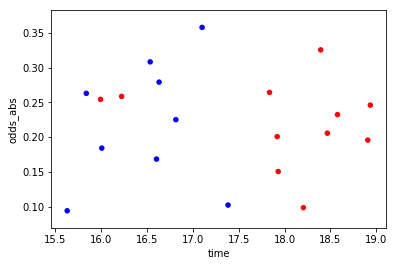

In [33]:
colors = {'white':'red', 'POC':'blue'}
terr.plot.scatter('time', 'odds_abs', c=terr['race'].apply(lambda x: colors[x]))

In [61]:
np.mean(terr[terr['race'] == 'POC'])

log_odds          -0.079180
vocab_size      6059.500000
time              16.484375
dem_odds           0.000857
rep_odds           0.000817
overall_odds       0.000755
odds_ratio         0.930393
odds_abs           0.117676
dtype: float64

In [62]:
np.mean(craz[craz['race'] == 'POC'])

log_odds          -0.079180
vocab_size      6059.500000
time              16.484375
dem_odds           0.000857
rep_odds           0.000817
overall_odds       0.000755
odds_ratio         0.930393
odds_abs           0.117676
dtype: float64

In [35]:
1 / np.mean(terr[terr['race'] == 'white'])

log_odds     -4.521964
vocab_size    0.000202
time          0.055728
odds_ratio    1.245368
odds_abs      4.521964
dtype: float64

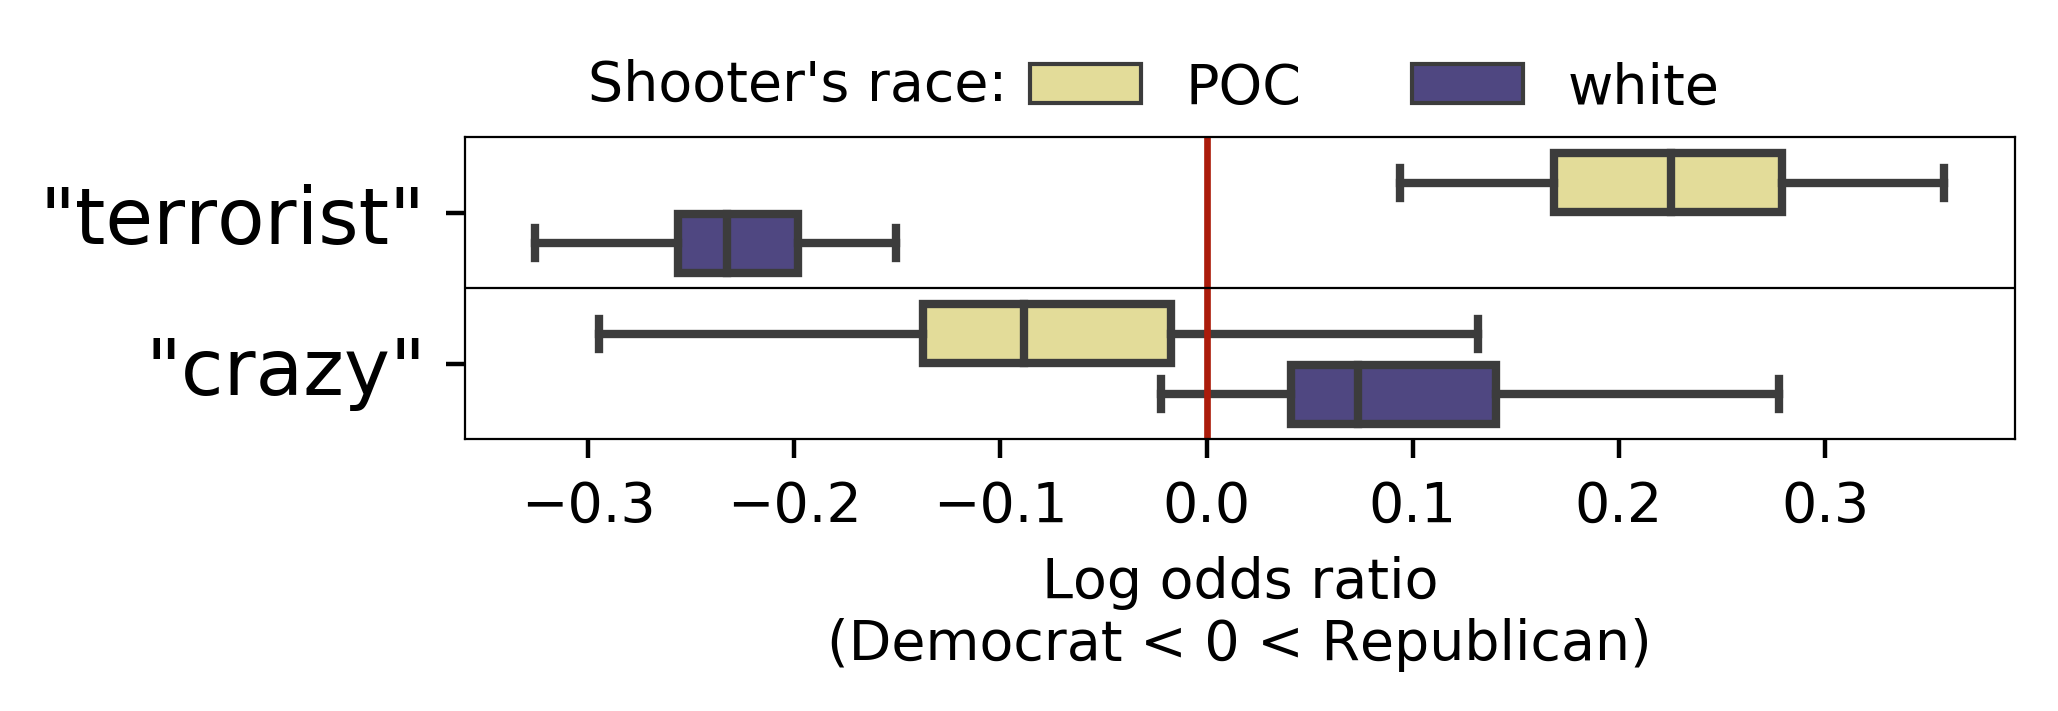

In [6]:
f = plt.figure(dpi=400, figsize=(5,1))
ax = sns.boxplot(data=concat, x="log_odds",y='word', hue="race", orient="h", palette=sns.color_palette(['#F0E68C', '#483D8B']), fliersize=0)
plt.axvline(x=0, color='#AB1C0B', linewidth=1.2)
plt.axhline(y=0.5, color='black', linewidth=.4)
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=14)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
ax.text(-.3,-0.75, "Shooter's race:")
l = ax.legend(bbox_to_anchor=(.35, 1), loc=3, borderaxespad=0., ncol=2, frameon=False)
#l.set_title("Shooter's race")

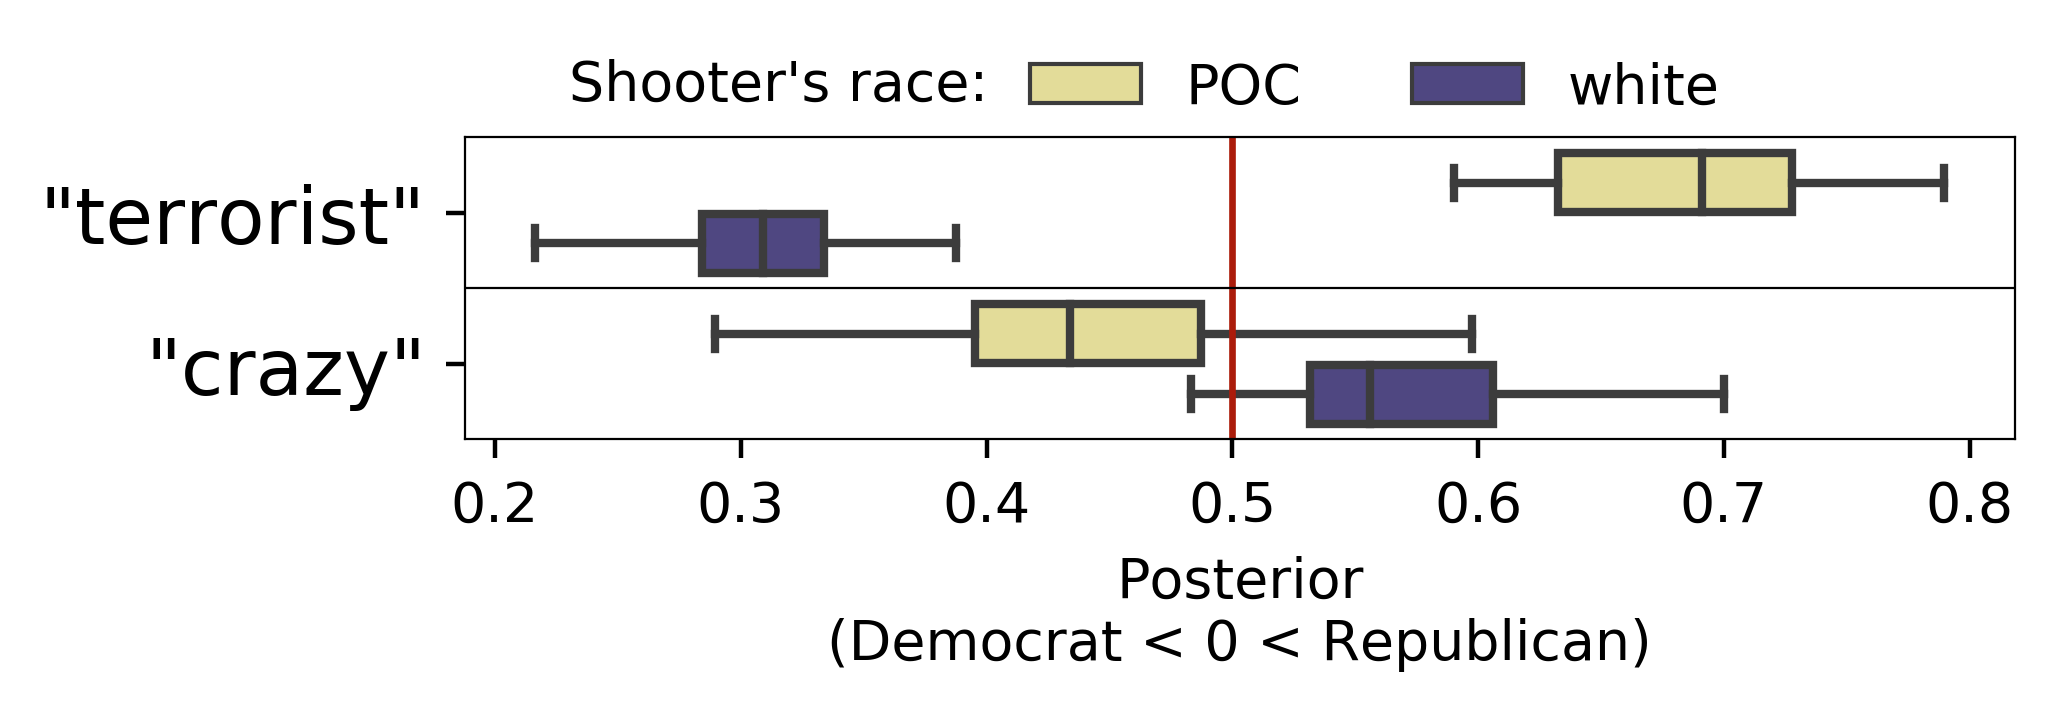

In [14]:
f = plt.figure(dpi=400, figsize=(5,1))
ax = sns.boxplot(data=concat, x="posterior",y='word', hue="race", orient="h", palette=sns.color_palette(['#F0E68C', '#483D8B']), fliersize=0)
plt.axvline(x=0.5, color='#AB1C0B', linewidth=1.2)
plt.axhline(y=0.5, color='black', linewidth=.4)
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=14)
ax.set_xlabel('Posterior\n(Democrat < 0 < Republican)')
ax.text(0.23,-0.75, "Shooter's race:")
l = ax.legend(bbox_to_anchor=(.35, 1), loc=3, borderaxespad=0., ncol=2, frameon=False)

Text(0.5, 0, 'Log odds ratio\n(Democrat < 0 < Republican)')

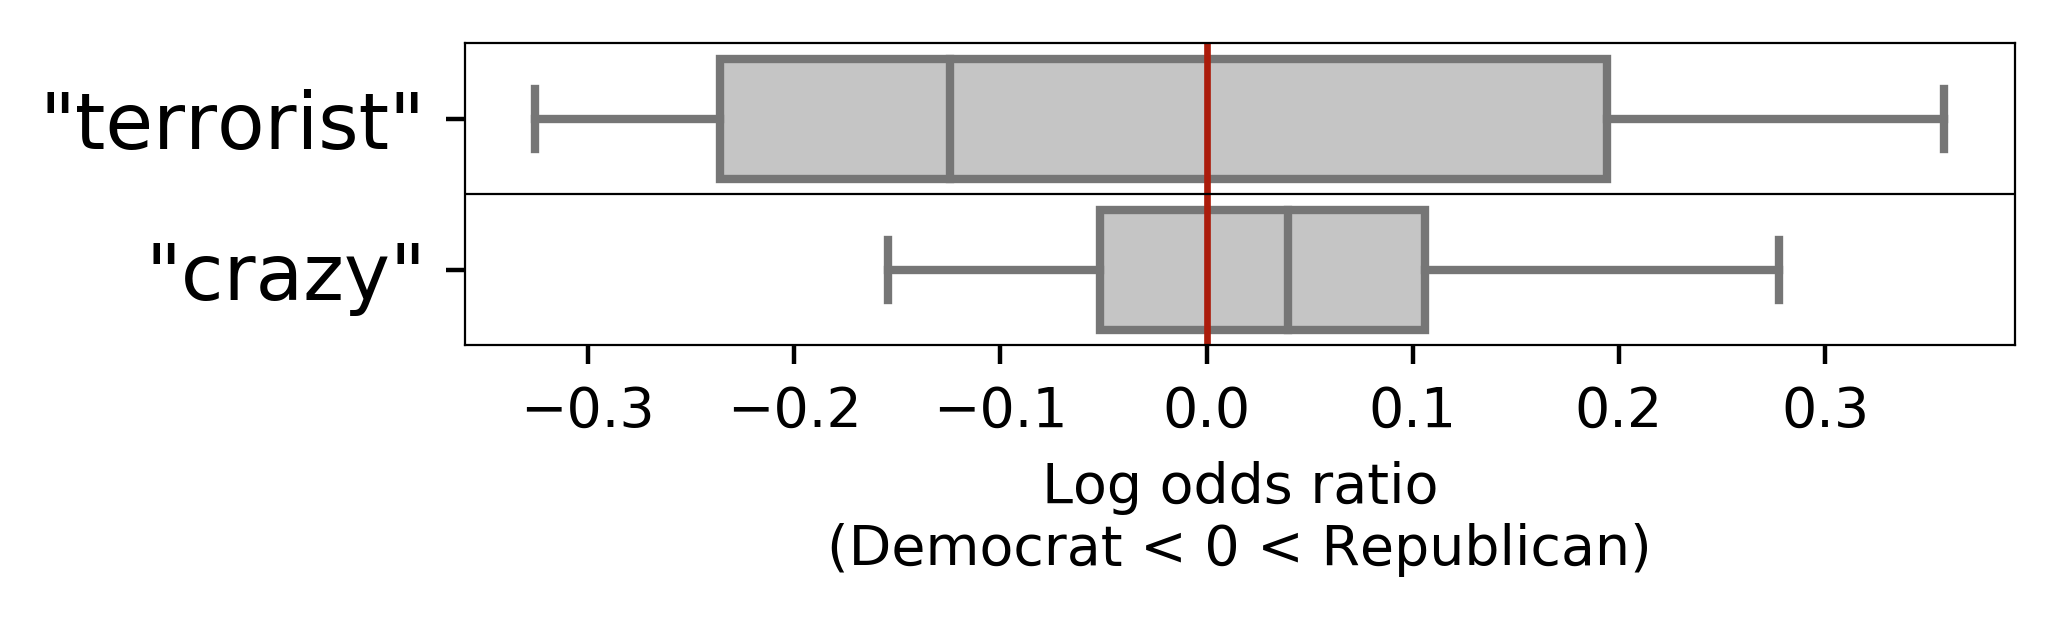

In [8]:
f = plt.figure(dpi=400, figsize=(5,1))
ax = sns.boxplot(data=concat, x="log_odds",y='word', orient="h", palette=sns.color_palette(['#C5C5C5', '#C5C5C5']), fliersize=0)
plt.axvline(x=0, color='#AB1C0B', linewidth=1.2)
plt.axhline(y=0.5, color='black', linewidth=.4)
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=14)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')

Text(0.5, 0, 'Log odds ratio\n(Democrat < 0 < Republican)')

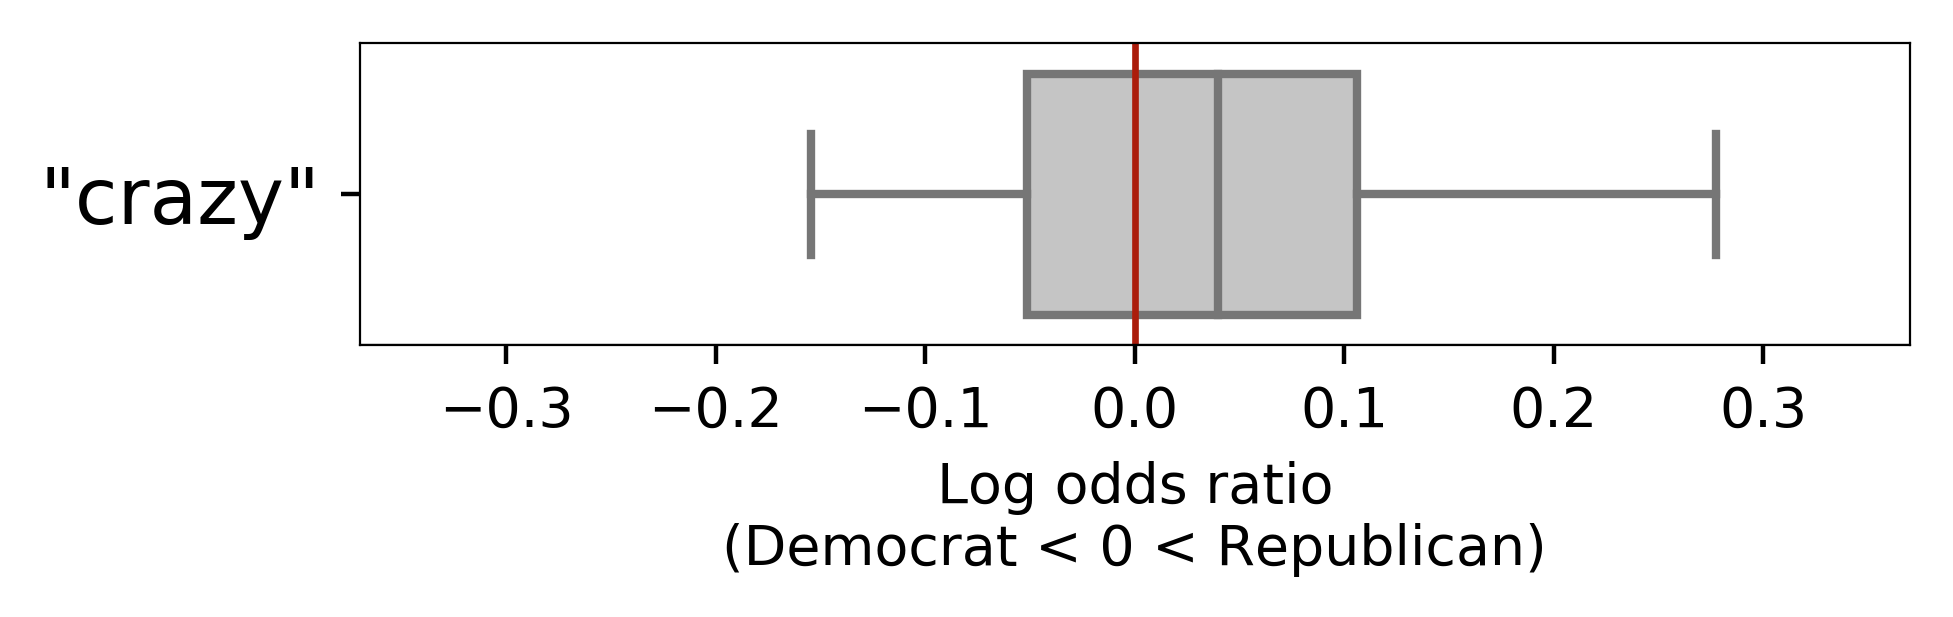

In [23]:
f = plt.figure(dpi=400, figsize=(5,1))
ax = sns.boxplot(data=concat[concat.word=='"crazy"'], x="log_odds",y='word', orient="h", palette=sns.color_palette(['#C5C5C5', '#C5C5C5']), fliersize=0)
plt.axvline(x=0, color='#AB1C0B', linewidth=1.2)
plt.axhline(y=0.5, color='black', linewidth=.4)
plt.xlim(-.37, .37)
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=14)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')

In [140]:
concat

,event,log_odds,vocab_size,race,time,dem_odds,rep_odds,overall_odds,mutual_information,posterior,chi_square,odds_ratio,odds_abs,word,race_bin
0,Orlando,0.308254,36966,Middle Eastern,16.533333,0.001999,0.005288,0.003667,0.015495,0.727905,7365.985415,1.361046,0.308254,"""terrorist""",Non-Caucasian
1,Vegas,-0.264441,26604,Caucasian,17.836111,0.004165,0.002422,0.002860,0.002767,0.309210,1195.569912,0.767635,0.264441,"""terrorist""",Caucasian
2,Parkland,-0.098519,9893,Caucasian,18.205556,0.000569,0.000266,0.000508,0.000195,0.420600,27.226735,0.906179,0.098519,"""terrorist""",Caucasian
3,Dallas,0.168401,5872,African American,16.602778,0.001211,0.002631,0.001692,0.001466,0.630919,177.567760,1.183411,0.168401,"""terrorist""",Non-Caucasian
4,Sutherland Springs,-0.150623,4531,Caucasian,17.930556,0.002714,0.001761,0.002209,0.000760,0.387761,72.546800,0.860172,0.150623,"""terrorist""",Caucasian
5,Thousand Oaks,-0.246086,3120,Caucasian,18.936111,0.000554,0.000130,0.000431,0.000598,0.285361,29.664853,0.781855,0.246086,"""terrorist""",Caucasian
6,Santa Fe,-0.205716,3016,Caucasian,18.466667,0.000924,0.000268,0.000743,0.000538,0.324946,21.381627,0.814065,0.205716,"""terrorist""",Caucasian
7,Pittsburgh,-0.195707,2023,Caucasian,18.908333,0.000828,0.000288,0.000666,0.000305,0.340280,9.563275,0.822253,0.195707,"""terrorist""",Caucasian
8,San Bernardino,0.184151,2010,Middle Eastern,16.005556,0.006694,0.014984,0.009650,0.007588,0.641559,264.117616,1.202197,0.184151,"""terrorist""",Non-Caucasian
9,Nashville,-0.325552,1733,Caucasian,18.394444,0.003053,0.000524,0.002202,0.006528,0.216409,137.681353,0.722128,0.325552,"""terrorist""",Caucasian


In [28]:
concat.loc[concat['race'] == 'African American, Middle Eastern', 'race']  = 'African American, Middle Eastern, Asian'
concat.loc[concat['race'] == 'Asian', 'race']  = 'African American, Middle Eastern, Asian'


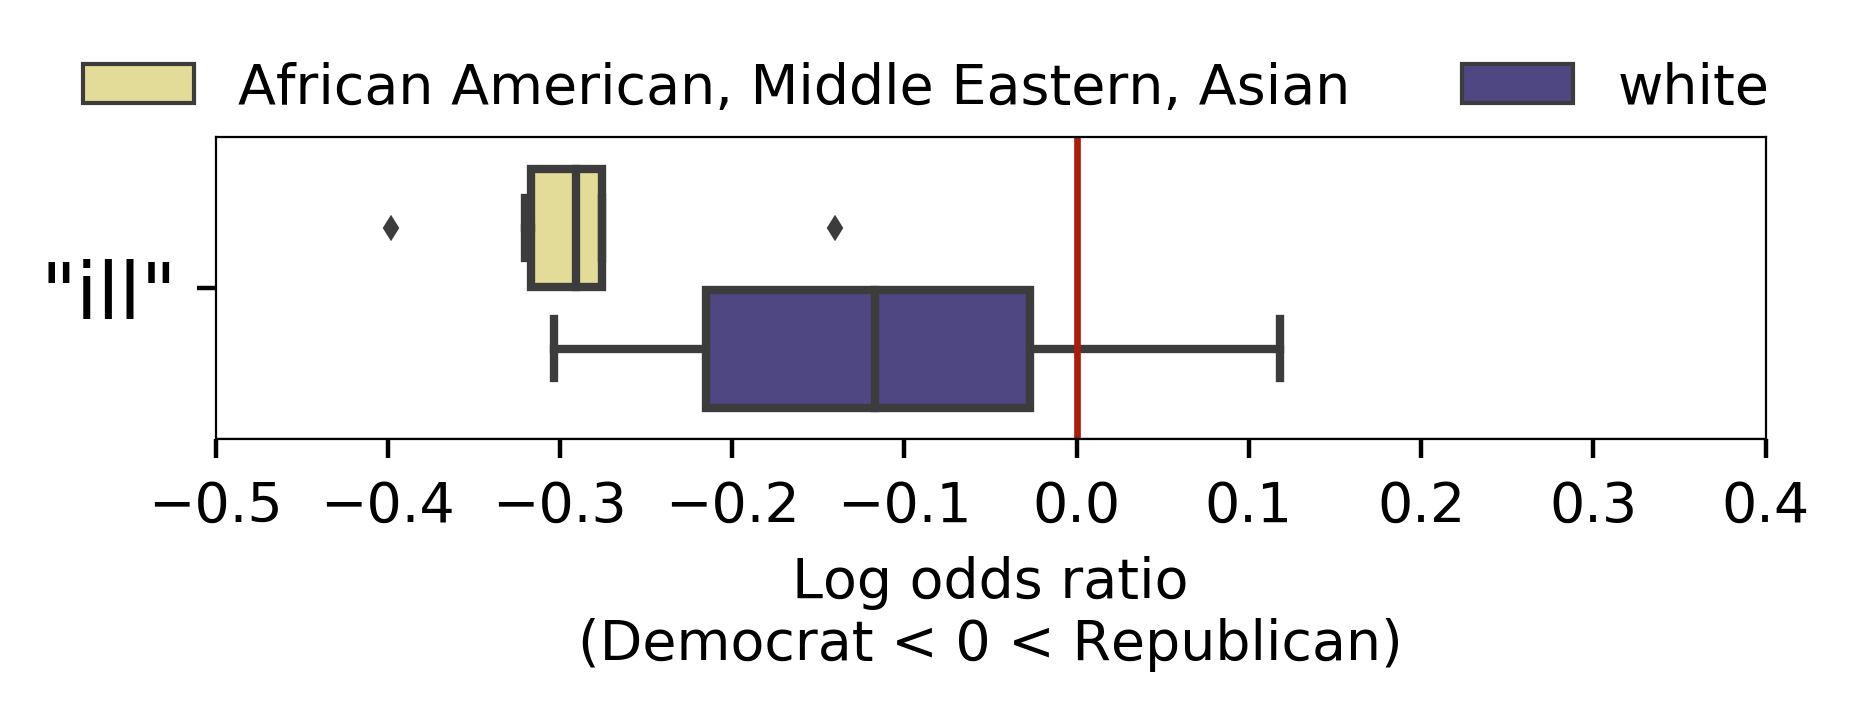

In [36]:
f = plt.figure(dpi=400, figsize=(5,1))
word = "ill"
sub = concat[concat.word=='"'+word+'"']
#print(sub)
ax = sns.boxplot(data=concat[concat.word=='"'+word+'"'], x="log_odds",y='word', hue="race", orient="h",palette=sns.color_palette(['#F0E68C', '#483D8B']), fliersize=2)
#ax = sns.stripplot(data=sub, x="log_odds",y='word', hue="race", dodge=False, orient="h", edgecolor='black', size=9, jitter=False, palette=sns.color_palette(['#F0E68C', '#483D8B']), linewidth=1)
#ax = sns.stripplot(data=concat[concat.word=='"'+word+'"'], x="log_odds",y='word', orient="h", edgecolor='black', size=9, jitter=False, color='grey', linewidth=1)

plt.axvline(x=0, color='#AB1C0B', linewidth=1.2)
plt.axhline(y=0.5, color='black', linewidth=.4)
xlim_1 = -.5
plt.xlim(xlim_1, .4)
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=14)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
#ax.text(xlim_1 +.05,-0.63, "Shooter's race:")
l = ax.legend(bbox_to_anchor=(xlim_1 +.4, 1), loc=3, borderaxespad=0., ncol=2, frameon=False)
#l.set_title("Shooter's race")

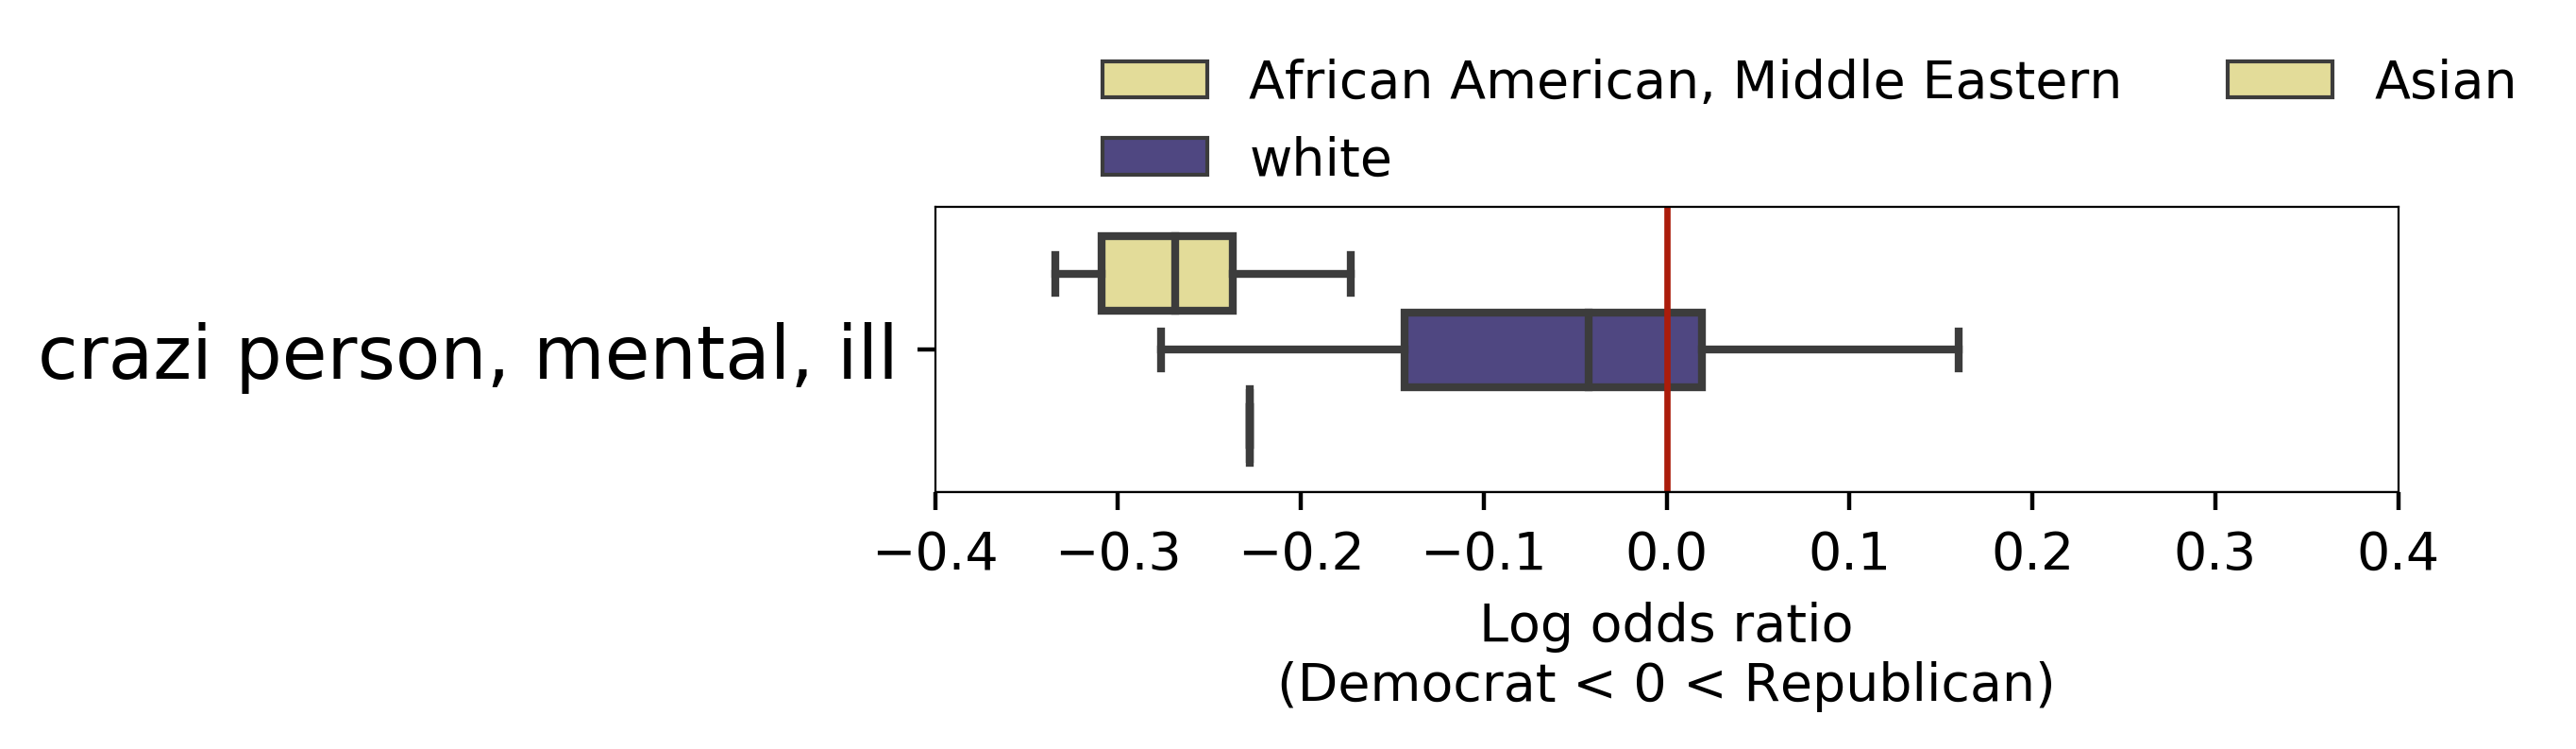

In [21]:
f = plt.figure(dpi=400, figsize=(5,1))
#print(sub)
ax = sns.boxplot(data=mental_df, x="log_odds",y='word', hue="race", orient="h",palette=sns.color_palette(['#F0E68C', '#483D8B']), fliersize=2)
#ax = sns.stripplot(data=mental_df, x="log_odds",y='word', hue="race", dodge=False, orient="h", edgecolor='black', size=9, jitter=False, palette=sns.color_palette('husl'), linewidth=1)
#ax = sns.stripplot(data=concat[concat.word=='"'+word+'"'], x="log_odds",y='word', orient="h", edgecolor='black', size=9, jitter=False, color='grey', linewidth=1)

plt.axvline(x=0, color='#AB1C0B', linewidth=1.2)
plt.axhline(y=0.5, color='black', linewidth=.4)
xlim_1 = -.4
plt.xlim(xlim_1, .4)
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=14)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
#ax.text(xlim_1 +.05,-0.63, "Shooter's race:")
l = ax.legend(bbox_to_anchor=(xlim_1 +.5, 1), loc=3, borderaxespad=0., ncol=2, frameon=False)
#l.set_title("Shooter's race")

In [119]:
f = plt.figure(dpi=400, figsize=(5,1))
ax = sns.boxplot(data=df, x="log_odds",y='race', orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.plot([0,0], [-1, 20], linewidth=1, color='grey')
ax.set_ylabel("Shooter's race")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio of "'+word+'"\n(Democrat < 0 < Republican)')

NameError: name 'df' is not defined

<Figure size 2000x400 with 0 Axes>

In [12]:
for i, g in df.groupby('race'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

POC
Ttest_1sampResult(statistic=-1.7660822681325092, pvalue=0.12072527692513597)
white
Ttest_1sampResult(statistic=3.6709396041707842, pvalue=0.004310419549140847)


## Find words whose use differs the most depending on the shooter's race

In [13]:
# get all words that are not missing from more than three events
no_events = len(events)
shared_vocab = {}
for e in events:
    vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    for w in vocab:
        if w in shared_vocab:
            shared_vocab[w] += 1
        else:
            shared_vocab[w] = 1
shared_vocab = [k for k, v in shared_vocab.items() if v > (no_events-5)]

In [14]:
len(shared_vocab)

236

In [15]:
def get_val(vals):
    return np.abs(np.mean(vals))

In [18]:
words = []
differences = []
overall_odds = []
odds_white_all = []
odds_poc_all = []
t_stats_all = []
t_stats_white = []
t_stats_poc = []
for w in shared_vocab:
    odds_white = []
    odds_poc = []
    odds_all = []
    for e in events:
        # format name
        log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds.npy')
        vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
        words2idx = {w: i for i, w in enumerate(vocab)}
        vocab_log_odds = {w: log_odds[3,i] for i, w in enumerate(vocab)}
    
        if w not in vocab_log_odds:
            continue
        if shooter_race[e] == 'white':
            odds_white.append(vocab_log_odds[w])
        else:
            odds_poc.append(vocab_log_odds[w])
        odds_all.append(vocab_log_odds[w])
    words.append(w)
    overall_odds.append(np.mean(odds_all))
    t_stats_all.append(ttest_1samp(odds_all, 0)[1])
    t_stats_white.append(ttest_1samp(odds_white, 0)[1])
    t_stats_poc.append(ttest_1samp(odds_poc, 0)[1])
    odds_white_all.append(np.mean(odds_white))
    odds_poc_all.append(np.mean(odds_poc))
    differences.append(get_val(odds_white) * get_val(odds_poc) * (np.sign(np.mean(odds_white)) - np.sign(np.mean(odds_poc))))

df = pd.DataFrame.from_dict({'word': words, 'difference': differences, 'overall': overall_odds, 't_test_overall': t_stats_all, 'white_odds':odds_white_all, 'odds_poc':odds_poc_all, 't_test_white':t_stats_white, 't_test_poc':t_stats_poc})
print(df)

               word  difference   overall  t_test_overall  white_odds  \
0              kill    0.000000 -0.000512    9.643667e-01   -0.000587   
1           shooter    0.000000  0.050079    9.546400e-03    0.054180   
2            famili    0.001413 -0.040693    9.707783e-02    0.007535   
3            victim    0.001429 -0.035106    1.052477e-01    0.008593   
4            attack    0.000000  0.077819    5.480669e-03    0.015487   
5               gun    0.000000 -0.081747    1.834977e-04   -0.074356   
6                 4    0.000000  0.008499    5.553426e-01    0.010728   
7            prayer    0.000000 -0.032529    1.883014e-01   -0.018563   
8             shoot    0.000000 -0.070884    1.840172e-03   -0.039405   
9             today    0.000000 -0.071751    1.572397e-03   -0.051844   
10           terror   -0.026563 -0.055246    1.288179e-01   -0.174616   
11        terrorist   -0.097421 -0.022536    6.755039e-01   -0.221171   
12            obama    0.000000  0.206936    1.6221

In [21]:
', '.join(df.sort_values('overall', ascending=False).loc[(df.overall > 0) & (df.t_test_overall < 0.05)]['word'])

'free, obama, #new, left, fox news, ap, fox, video, blame, #break, releas, polit, detail, prayer famili, motiv, updat, break news, secur, insid, investig, wit, identifi, press, break, report, confirm, media, killer, custodi, 6, sourc, polic, multipl, god, target, attack, involv, arrest, crime, respond, injur, scene, suspect, activ shooter, offici, shooter, activ'

In [22]:
', '.join(df.sort_values('overall', ascending=True).loc[(df.overall < 0) & (df.t_test_overall < 0.05)]['word'])

'gun violenc, mass shoot, nra, violenc, fuck, #guncontrol, america, mass, heart, send, safe, feel, male, mental, countri, love, thought, shit, american, communiti, senseless, talk, damn, chang, week, word, men, read, white, ppl, day, thought prayer, folk, end, trump, tweet, happen, care, gun, won, sick, stay, hear, act, close, sad, good, hey, today, shoot, friend, home, shot kill, lost, wait, yesterday, tragedi, guy, matter, time, hope, thing, problem, stop, death, life, peopl, man, live, make'

In [23]:
', '.join(df.sort_values('white_odds', ascending=False).loc[(df.white_odds > 0) & (df.t_test_white < 0.05)]['word'])

'free, left, #break, ap, #new, updat, detail, blame, releas, video, wit, fox news, insid, prayer victim, obama, confirm, polit, break, break news, press, prayer famili, sourc, polic, fox, involv, identifi, report, secur, 6, investig, scene, target, injur, latest, suspect, #shoot, multipl, custodi, media, open fire, pray, activ shooter, crazi, local, area, activ, fire, respond, 8, offic, god, crime, victim famili, incid, lot, rt, citi, 1, gunman, 10, dead, point'

In [24]:
', '.join(df.sort_values('white_odds', ascending=True).loc[(df.white_odds < 0) & (df.t_test_white < 0.05)]['word'])

'gun violenc, fuck, terrorist, male, white, mass shoot, violenc, nra, america, american, terror, send, #guncontrol, terrorist attack, won, word, safe, hey, talk, countri, shit, feel, trump, folk, thought prayer, damn, thought, mass, tweet, heart, week, read, act, wow, day, care, love, time, yesterday, nation, communiti, guess, wait, gun, good, ppl, home, sick, shot kill, matter, call, hear, today, live, peopl'

In [25]:
', '.join(df.sort_values('odds_poc', ascending=False).loc[(df.odds_poc > 0) & (df.t_test_poc < 0.05)]['word'])

'obama, terrorist attack, free, terrorist, muslim, fox news, fox, attack, killer, shooter kill, motiv, ap, call, god, cop, respond'

In [26]:
', '.join(df.sort_values('odds_poc', ascending=True).loc[(df.odds_poc < 0) & (df.t_test_poc < 0.05)]['word'])

'gun violenc, mass shoot, nra, mental, violenc, #guncontrol, mass, heart, senseless, love, tragic, fuck, communiti, feel, america, thought, end, safe, tragedi, countri, ppl, happen, sad, day, read, week, send, damn, lost, shit, open, shoot, stori, hear, stay, friend, close, year, die, famili, today, talk, gun, thought prayer, victim, thing, stop, coverag, peopl kill, wasn, guy, problem, home, peopl, man, area'

In [48]:
# Republicans are more likely to say these words when the shooter is white and Democrats are more 
# likely to say these words when the shooter is POC
', '.join(df.sort_values('difference', ascending=False).loc[df.difference > 0]['word'])

'crazi, latest, #shoot, fatal, prayer victim, open, lot, detail, #break, open fire, incid, coverag, rt, victim famili, local, area, scene, wrong, peopl dead, offic, affect, situat, cnn, 1, involv, famili victim, leav, year, 8, hour, citi, news, updat, suspect, start, turn, dead, tonight, peopl kill, stori, hurt, bad, victim, famili, watch, injur, person, fire, activ, gunman, twitter, peopl shot, fact, find, pray, post, 3, state, show'

In [46]:
# Democrats are more likely to say these words when the shooter is white and Republicans are more 
# likely to say these words when the shooter is POC
', '.join(df.sort_values('difference', ascending=True).loc[df.difference < 0]['word'])

'terrorist, muslim, terror, call, guess, hey, white, black, mention, shooter kill, respons, peac, murder, back'

# produce LaTeX for appendix

In [20]:
for e in events:
    name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
    log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds_normed.npy')
    vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    words2idx = {w: i for i, w in enumerate(vocab)}
    
    # keep words / phrases if they occur at least ten times
    vocab_log_odds = {w: log_odds[3,i] for i, w in enumerate(vocab) if log_odds[0,i]>10}
    sorted_x = sorted(vocab_log_odds.items(), key=operator.itemgetter(1))
    print('\\paragraph{%s.}' %name)
    print('\\emph{Most Republican phrases:} ', ', '.join([k + ' (%.2f)' %v for k, v in reversed(sorted_x[-20:])]).replace('#', '\#'),'\\\\')
    print('\emph{Most Democrat phrases:} ', ', '.join([k + ' (%.2f)' %v for k, v in sorted_x[:20]]).replace('#', '\#'))

\paragraph{Chattanooga.}
\emph{Most Republican phrases:}  obama (7.41), gun free (5.89), zone (5.70), free (5.69), free zone (5.53), flag (5.33), \#tcot (5.33), \#chattanoogaattack (5.13), \#wakeupamerica (4.94), islam (4.69), \#obama (4.01), \#islam (3.83), attack (3.67), \#gunfreezon (3.66), lower (3.66), liber (3.54), arm (3.44), workplac (3.32), white hous (3.23), workplac violenc (3.21) \\
\emph{Most Democrat phrases:}  blame georg (-8.62), bush invad (-8.62), invad iraq (-8.60), invad (-8.60), base lie (-8.55), georg bush (-8.53), war base (-8.51), lie happen (-8.51), georg (-8.35), iraq war (-8.31), iraq (-8.24), bush (-7.77), lie (-7.45), \#charleston (-6.99), mass (-6.82), \#lafayett (-6.48), happen (-6.19), \#charlestonshoot (-5.96), blame (-5.40), \#gunsens (-5.09)
\paragraph{Roseburg.}
\emph{Most Republican phrases:}  obama (8.02), \#2a (6.28), \#obama (6.01), gun free (5.37), \#tcot (5.32), free (5.22), christian (5.09), zone (5.08), chicago (5.06), shooter (4.78), free zo

\paragraph{Thousand Oaks.}
\emph{Most Republican phrases:}  california (16.51), zone (12.80), free (12.40), gun free (12.22), free zone (11.80), bar (9.98), california bar (9.61), strictest (9.01), strictest gun (8.52), men (7.63), \#foxnew (7.33), killer ian (7.12), california strictest (7.11), fear resid (7.11), report killer (7.08), prayer massacr (7.04), communist (7.04), long mock (7.00), mock hope (6.80), ian long (6.77) \\
\emph{Most Democrat phrases:}  inact (-17.50), pattern (-17.46), pattern inact (-17.45), shoot pattern (-17.43), shoot (-16.92), januari (-13.09), inact januari (-12.92), \#guncontrolnow (-8.09), mass shoot (-7.89), day (-7.34), fuck (-6.94), nra (-6.94), violenc (-6.71), mother (-6.64), mass (-6.59), thought (-6.44), high (-6.37), januar (-6.22), inact januar (-6.15), \#potus (-6.05)


In [28]:
cluster_names = {0: "shooter's identity\n& ideology",
 1: 'news',
 2: 'victims & location',
 3: 'laws & policy',
 4: 'investigation',
 5: 'solidarity',
 6: 'remembrance',
 7: 'other'}

cluster_colors = {0: 'F2D7D5',
                  1: 'FCF3CF',
                  2: 'EAEDED',
                  3: 'D0ECE7',
                  4: 'D6EAF8',
                  5: 'EBDEF0',
                  6: 'D7FFCE',
                  7: 'FFE8DD'
}
print('\\begin{table}[]')
print('\\centering')
print('\\begin{tabular}{|l|}')
print('\\hline')
print('\\textbf{Topic colors} \\\\ \\hline')
for i in range(NUM_CLUSTERS):
    print('\\rowcolor[HTML]{'+cluster_colors[i] +'}')
    print(cluster_names[i], '\\\\ \\hline')
print('\\end{tabular}')
print('\\end{table}')

    

for e in events:
    name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
    print('\\begin{table*}[!h]')
    print('\\centering')
    print('\\resizebox{\linewidth}{!}{%')

    print('\\begin{tabular}{|l|l|}')
    
    
    print('\\hline')
    print('Republican & Democrat\\\\ \\hline')
    log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds_topics.npy')
    vocab = open(TWEET_DIR +e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    words2idx = {w: i for i, w in enumerate(vocab)}
    for j in range(NUM_CLUSTERS):
        print('\\rowcolor[HTML]{'+cluster_colors[j] +'}')
        vocab_log_odds = {w: log_odds[j,3,i] for i, w in enumerate(vocab) if log_odds[j,0,i]>10}
        sorted_x = sorted(vocab_log_odds.items(), key=operator.itemgetter(1))

        print(', '.join([k + ' (%.2f)' %v for k, v in reversed(sorted_x[-5:])]).replace('#', '\#'), '&', ', '.join([k + ' (%.2f)' %v for k, v in sorted_x[:5]]).replace('#', '\#'), '\\\\')
        print('\\hline')
    print('\\end{tabular} %')
    print('}')
    print('\\caption{Most partisan phrases per topic for \\textbf{'+name+'}. Brackets show the $z$-scores of the log odds of each phrase.}')
    print('\\end{table*}')

\begin{table}[]
\centering
\begin{tabular}{|l|}
\hline
\textbf{Topic colors} \\ \hline
\rowcolor[HTML]{F2D7D5}
shooter's identity
& ideology \\ \hline
\rowcolor[HTML]{FCF3CF}
news \\ \hline
\rowcolor[HTML]{EAEDED}
victims & location \\ \hline
\rowcolor[HTML]{D0ECE7}
laws & policy \\ \hline
\rowcolor[HTML]{D6EAF8}
investigation \\ \hline
\rowcolor[HTML]{EBDEF0}
solidarity \\ \hline
\rowcolor[HTML]{D7FFCE}
remembrance \\ \hline
\rowcolor[HTML]{FFE8DD}
other \\ \hline
\end{tabular}
\end{table}
\begin{table*}[!h]
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{|l|l|}
\hline
Republican & Democrat\\ \hline
\rowcolor[HTML]{F2D7D5}
\#obama (0.45), toler (0.45), presid (0.45), \#wakeupamerica (0.45), celebr (0.45) & blame georg (-0.94), invad iraq (-0.94), bush invad (-0.94), iraq war (-0.94), base lie (-0.94) \\
\hline
\rowcolor[HTML]{FCF3CF}
zone (0.35), fox news (0.34), 5th victim (0.33), \#tcot (0.33), class (0.32) & mass (-0.68), \#prayforchattanooga (-0.37), horrif (-0.37), \#break

\#americafirst (0.80), killari (0.80), told word (0.80), carri terror (0.80), \#buildthewal (0.80) & learn hate (-0.59), hint wasn (-0.59), hate hint (-0.59), wasn osama (-0.59), shot girl (-0.59) \\
\hline
\end{tabular} %
}
\caption{Most partisan phrases per topic for \textbf{Orlando}. Brackets show the $z$-scores of the log odds of each phrase.}
\end{table*}
\begin{table*}[!h]
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{|l|l|}
\hline
Republican & Democrat\\ \hline
\rowcolor[HTML]{F2D7D5}
ag lynch (0.45), doj (0.45), lectur (0.45), \#maga (0.45), \#dallaspoliceshoot \#bluelivesmatt (0.45) & \#disarmh (-0.90), communiti color (-0.90), \#disarmh address (-0.90), address \#gunviol (-0.90), 2 \#disarmh (-0.90) \\
\hline
\rowcolor[HTML]{FCF3CF}
\#pjnet (0.57), mt prayer (0.57), \#bluelivesmatt \#pjnet (0.57), panther (0.57), \#tcot (0.57) & lawrenc (-0.73), npr (-0.69), bbc (-0.63), \#enough (-0.60), read (-0.58) \\
\hline
\rowcolor[HTML]{EAEDED}
3 (0.36), attack (0.33), \#dalla

injur stand (0.60), impeach postpon (0.60), green trump (0.60), \#dtmag (0.60), stand countri (0.60) & receiv year (-0.79), click full (-0.79), raw stori (-0.79), \#theresist (-0.79), \#bakersfield (-0.79) \\
\hline
\rowcolor[HTML]{FFE8DD}
kain (0.67), tim kain (0.67), kain attack (0.67), room wish (0.67), kaya (0.67) & \#tytliv (-0.72), \#notmypresid (-0.72), senjohnthun (-0.72), prayer stop (-0.72), prayer nice (-0.72) \\
\hline
\end{tabular} %
}
\caption{Most partisan phrases per topic for \textbf{Vegas}. Brackets show the $z$-scores of the log odds of each phrase.}
\end{table*}
\begin{table*}[!h]
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{|l|l|}
\hline
Republican & Democrat\\ \hline
\rowcolor[HTML]{F2D7D5}
news (0.60), motiv (0.42), blame (0.34), talk (0.32), tweet (0.31) & live stack (-0.29), furnitur (-0.29), bibl furnitur (-0.29), stack (-0.27), stack bibl (-0.27) \\
\hline
\rowcolor[HTML]{FCF3CF}
detail (0.34), involv (0.34), \#coloradoshoot (0.34), park lot (0.34),

# compare relative frequencies

In [33]:
word = []
relfreq = []
event_names = []
race = []
for e in events:
    # format name
    name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
    log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds.npy')
    vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    words2idx = {w: i for i, w in enumerate(vocab)}

    total_prior = log_odds[0,:].sum()
    if 'terrorist' in words2idx:
        relfreq.append(log_odds[0, words2idx['terrorist']] / total_prior)
        event_names.append(name)
        race.append(shooter_race[e])
        word.append('terrorist')
    if 'crazi' in words2idx:
        relfreq.append(log_odds[0, words2idx['crazi']] / total_prior)
        event_names.append(name)
        race.append(shooter_race[e])
        word.append('crazy')
    
    
df = pd.DataFrame.from_dict({'event': event_names, 'word':word, 'relfreq':relfreq, 'race':race})

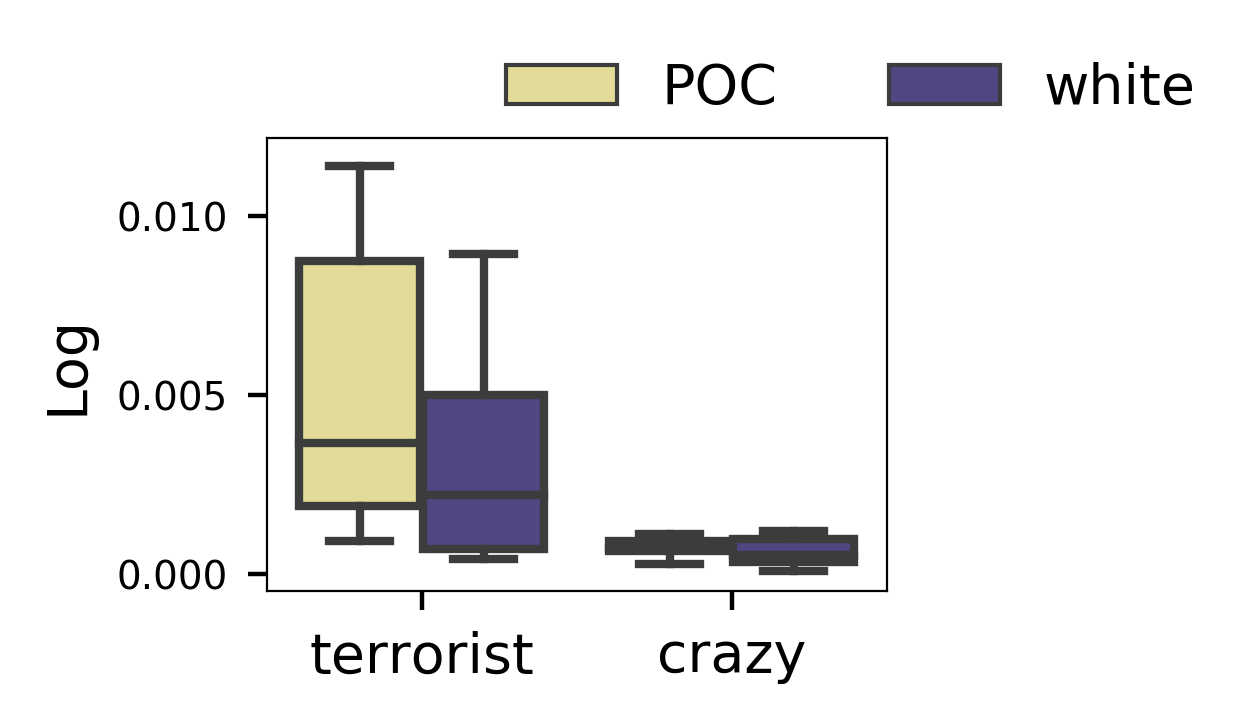

In [34]:
f = plt.figure(dpi=400, figsize=(2,1.5))
ax = sns.boxplot(data=df, x="word",y='relfreq', hue='race', palette=sns.color_palette(['#F0E68C', '#483D8B']), fliersize=0)
#plt.axvline(x=0, color='#AB1C0B', linewidth=1.2)
#plt.axhline(y=0.5, color='black', linewidth=.4)
ax.set_ylabel("Log")
ax.set_xlabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=7)
#ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
#ax.text(-.3,-0.75, "Shooter's race:")
l = ax.legend(bbox_to_anchor=(.35, 1), loc=3, borderaxespad=0., ncol=2, frameon=False)
#l.set_title("Shooter's race")

No handles with labels found to put in legend.


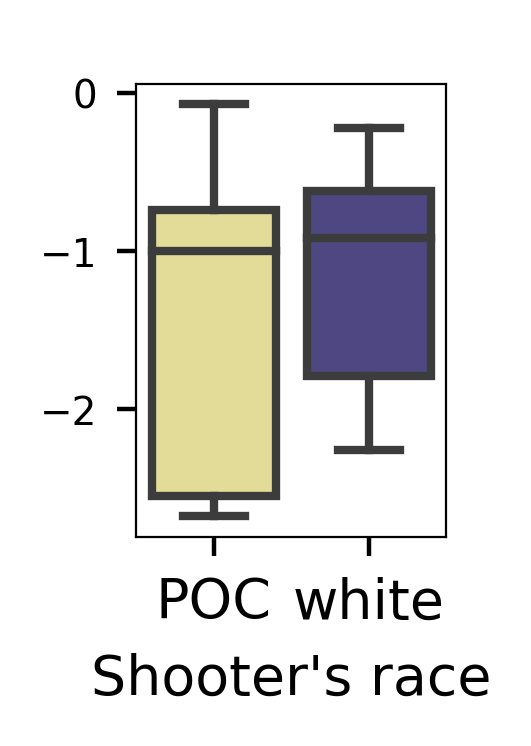

In [22]:
f = plt.figure(dpi=400, figsize=(1,1.5))
ax = sns.boxplot(data=df, x="race",y='odds', palette=sns.color_palette(['#F0E68C', '#483D8B']), fliersize=0)
#plt.axvline(x=0, color='#AB1C0B', linewidth=1.2)
#plt.axhline(y=0.5, color='black', linewidth=.4)
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=7)
plt.xlabel("Shooter's race")
#ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
#ax.text(-.3,-0.75, "Shooter's race:")
l = ax.legend(bbox_to_anchor=(.35, 1), loc=3, borderaxespad=0., ncol=2, frameon=False)
#l.set_title("Shooter's race")

In [20]:
odds = []
event_names = []
race = []
for e in events:
    # format name
    name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
    log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds.npy')
    vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    words2idx = {w: i for i, w in enumerate(vocab)}

    total_prior = log_odds[0,:].sum()
    if 'terrorist' in words2idx and 'crazi' in words2idx:
        odds.append(np.log((log_odds[0, words2idx['crazi']] / total_prior) / (log_odds[0, words2idx['terrorist']] / total_prior)))
        event_names.append(name)
        race.append(shooter_race[e])
df = pd.DataFrame.from_dict({'event': event_names, 'odds':odds, 'race':race})